In [1]:
!pip install ultralytics roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 982.4/982.4 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/

loading dataset

In [2]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="LpIOo51TriziCYxqzIZw")
project = rf.workspace("test-hmoom").project("cleaning_bot_dataset_2.0")
version = project.version(3)
dataset = version.download("voc")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to cleaning_bot_dataset_2.0-3 in voc:: 100%|██████████| 5335/5335 [00:01<00:00, 4657.20it/s]


imports

In [3]:
import os
import cv2
from ultralytics import YOLO
import numpy as np
import pandas as pd
import tensorflow as tf
import xml.etree.ElementTree as et
import plotly.express as px
import plotly.io as pio
import matplotlib.pyplot as plt
from PIL import Image
from skimage import io
from glob import glob
from tensorflow.keras.models import Model
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.layers import Dense, Dropout, Flatten
import shutil
import json
from google.colab import files
import zipfile
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from collections import Counter
import random
from tensorflow.keras.callbacks import EarlyStopping
import plotly.graph_objects as go
from sklearn.metrics import precision_recall_curve, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix



Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
def rename_folder(folder_path, new_name):
    # Get the directory containing the folder
    parent_dir = os.path.dirname(folder_path)

    # Create the new path with the new folder name
    new_folder_path = os.path.join(parent_dir, new_name)

    # Rename the folder
    os.rename(folder_path, new_folder_path)

    print(f"Folder renamed from {folder_path} to {new_folder_path}")

# Find all matching folders using glob function
folder_paths = glob('/content/cleaning_bot_dataset_2.0-*')

if folder_paths:
    folder_path = folder_paths[0]  # Use the first match
    new_folder_name = 'cleaning_bot_object_dataset'  # New folder name
    rename_folder(folder_path, new_folder_name)
else:
    print("No matching folders found.")

Folder renamed from /content/cleaning_bot_dataset_2.0-3 to /content/cleaning_bot_object_dataset


splitting dataset into separate images and xml folders

In [5]:
def move_files_by_extension(source_directory, target_directory, file_extension):
    # Ensure the target directory exists (create it if it doesn't)
    os.makedirs(target_directory, exist_ok=True)

    # Walk through the source directory and its subdirectories
    for root, dirs, files in os.walk(source_directory):
        for file in files:
            # Check if the file has the specified extension
            if file.endswith(file_extension):
                # Create full path for source and destination
                source_path = os.path.join(root, file)
                target_path = os.path.join(target_directory, file)

                # Move the file
                shutil.move(source_path, target_path)
                print(f"Moved: {source_path} to {target_path}")

def organize_files(folder_name):
    # Define source and target directories based on the folder name
    source_directory = os.path.join("/content/cleaning_bot_object_dataset/", folder_name)
    xml_target_directory = os.path.join(source_directory, "xmls")
    images_target_directory = os.path.join(source_directory, "images")

    # Create target directories if they don't exist
    os.makedirs(xml_target_directory, exist_ok=True)
    os.makedirs(images_target_directory, exist_ok=True)

    # Move XML files
    move_files_by_extension(source_directory, xml_target_directory, ".xml")

    # Move JPG files
    move_files_by_extension(source_directory, images_target_directory, ".jpg")

organize_files("test")
organize_files("train")
organize_files("valid")


Streaming output truncated to the last 5000 lines.
Moved: /content/cleaning_bot_object_dataset/train/WhatsApp-Image-2024-07-05-at-16-49-33_jpeg_jpg.rf.19c050730e7d6eeff00161cad08df985.jpg to /content/cleaning_bot_object_dataset/train/images/WhatsApp-Image-2024-07-05-at-16-49-33_jpeg_jpg.rf.19c050730e7d6eeff00161cad08df985.jpg
Moved: /content/cleaning_bot_object_dataset/train/augmented_1009_frame360_jpg.rf.39a7b1524091231a75b4001b7a8ae1d5.jpg to /content/cleaning_bot_object_dataset/train/images/augmented_1009_frame360_jpg.rf.39a7b1524091231a75b4001b7a8ae1d5.jpg
Moved: /content/cleaning_bot_object_dataset/train/23_jpg.rf.15f48eeea374d121c02f9f4b24e9f111.jpg to /content/cleaning_bot_object_dataset/train/images/23_jpg.rf.15f48eeea374d121c02f9f4b24e9f111.jpg
Moved: /content/cleaning_bot_object_dataset/train/dogs28_jpg.rf.70866a54eeaf383961cf14d4437c7bec.jpg to /content/cleaning_bot_object_dataset/train/images/dogs28_jpg.rf.70866a54eeaf383961cf14d4437c7bec.jpg
Moved: /content/cleaning_bot_ob

combine train, valid, test to process together and split later after preprocessing

In [6]:
# Define the source directories
source_dirs = ['/content/cleaning_bot_object_dataset/train', '/content/cleaning_bot_object_dataset/valid', '/content/cleaning_bot_object_dataset/test']

# Define the destination directory
destination_dir = '/content/cleaning_bot_object_dataset'
xml_dest_dir = os.path.join(destination_dir, 'xmls')
jpg_dest_dir = os.path.join(destination_dir, 'images')

# Create the destination directories if they do not exist
os.makedirs(xml_dest_dir, exist_ok=True)
os.makedirs(jpg_dest_dir, exist_ok=True)

# Copy XML and JPG files from source directories to destination directories
for src_dir in source_dirs:
    xml_src_dir = os.path.join(src_dir, 'xmls')
    jpg_src_dir = os.path.join(src_dir, 'images')

    # Copy XML files
    for filename in os.listdir(xml_src_dir):
        src_file = os.path.join(xml_src_dir, filename)
        dest_file = os.path.join(xml_dest_dir, filename)
        shutil.copy(src_file, dest_file)

    # Copy JPG files
    for filename in os.listdir(jpg_src_dir):
        src_file = os.path.join(jpg_src_dir, filename)
        dest_file = os.path.join(jpg_dest_dir, filename)
        shutil.copy(src_file, dest_file)

print("Files have been successfully combined.")


Files have been successfully combined.


In [7]:
def delete_folder(folder_path):

    if os.path.exists(folder_path):
        # Remove the folder and all its contents
        shutil.rmtree(folder_path)
        print(f"Folder '{folder_path}' and all its contents have been deleted.")
    else:
        print(f"Folder '{folder_path}' does not exist.")

In [8]:
folder_to_delete = '/content/cleaning_bot_object_dataset/train'
delete_folder(folder_to_delete)

folder_to_delete = '/content/cleaning_bot_object_dataset/valid'
delete_folder(folder_to_delete)

folder_to_delete = '/content/cleaning_bot_object_dataset/test'
delete_folder(folder_to_delete)

Folder '/content/cleaning_bot_object_dataset/train' and all its contents have been deleted.
Folder '/content/cleaning_bot_object_dataset/valid' and all its contents have been deleted.
Folder '/content/cleaning_bot_object_dataset/test' and all its contents have been deleted.


In [9]:
def count_files_in_folder(folder_path):
    # List all files in the folder
    files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    return len(files)

folder_path = '/content/cleaning_bot_object_dataset/xmls'
file_count = count_files_in_folder(folder_path)
print(f"Number of files in '{folder_path}': {file_count}")

folder_path = '/content/cleaning_bot_object_dataset/images'
file_count = count_files_in_folder(folder_path)
print(f"Number of files in '{folder_path}': {file_count}")


Number of files in '/content/cleaning_bot_object_dataset/xmls': 2666
Number of files in '/content/cleaning_bot_object_dataset/images': 2666


build xml parser

In [10]:
def parse_annotation(xml_file):
    tree = et.parse(xml_file)
    root = tree.getroot()

    annotation = {
        'filename': root.find('filename').text,
        'size': {
            'width': int(root.find('size/width').text),
            'height': int(root.find('size/height').text),
            'depth': int(root.find('size/depth').text),
        },
        'objects': []
    }

    for obj in root.findall('object'):
        obj_data = {
            'name': obj.find('name').text,
            'bndbox': {
                'xmin': int(obj.find('bndbox/xmin').text),
                'xmax': int(obj.find('bndbox/xmax').text),
                'ymin': int(obj.find('bndbox/ymin').text),
                'ymax': int(obj.find('bndbox/ymax').text),
            },
            'polygon': []
        }

        for i in range(1, 60):  # Assuming no more than 60 points in a polygon
            x = obj.find(f'polygon/x{i}')
            y = obj.find(f'polygon/y{i}')
            if x is not None and y is not None:
                obj_data['polygon'].append((float(x.text), float(y.text)))
            else:
                break

        annotation['objects'].append(obj_data)

    return annotation


In [11]:
# Specify the folder path
folder_path = '/content/cleaning_bot_object_dataset/xmls'

# Get a list of files in the folder
files = os.listdir(folder_path)

# Choose a random file
random_file = random.choice(files)

# Get the full path of the chosen file
xml_file = os.path.join(folder_path, random_file)
# xml_file = '/content/cleaning_bot_object_dataset/xmls/standing_8_11_23-71-_jpg.rf.ee430e8bb392e115f304698468892cad.xml'

parsed_data = parse_annotation(xml_file)

# Pretty-print the parsed data
print(json.dumps(parsed_data, indent=4))

{
    "filename": "human_28062023_170009_jpg.rf.ee0a9e0dcb70c4d1594a7d9f2cc5cfbd.jpg",
    "size": {
        "width": 299,
        "height": 299,
        "depth": 3
    },
    "objects": [
        {
            "name": "person",
            "bndbox": {
                "xmin": 22,
                "xmax": 145,
                "ymin": 1,
                "ymax": 300
            },
            "polygon": []
        }
    ]
}


find data distribution by parsing xmls

In [12]:
def parse_annotations_for_classes(xml_folder):
    """
    Parses annotation XML files and extracts labels.

    Args:
    xml_folder: Path to the folder containing XML files

    Returns:
    A list of labels extracted from the XML files
    """
    labels = []

    for xml_file in os.listdir(xml_folder):
        if xml_file.endswith('.xml'):
            tree = et.parse(os.path.join(xml_folder, xml_file))
            root = tree.getroot()

            for obj in root.findall('object'):
                label = obj.find('name').text
                # Filter out any non-relevant labels (e.g., if label is not empty)
                if label.strip():  # Make sure it's not an empty string or just whitespace
                    labels.append(label)

    return labels

def count_labels(labels):
    """
    Counts occurrences of each label.

    Args:
    labels: A list of labels

    Returns:
    A pandas DataFrame with counts of each label
    """
    label_counts = Counter(labels)
    label_df = pd.DataFrame(label_counts.items(), columns=['Label', 'Count'])
    label_df = label_df.sort_values(by='Count', ascending=False).reset_index(drop=True)
    return label_df

# Define paths
xml_folder_path = '/content/cleaning_bot_object_dataset/xmls'

# Parse annotations and count labels
labels = parse_annotations_for_classes(xml_folder_path)
label_distribution = count_labels(labels)

# Print the output
print(label_distribution)


         Label  Count
0        waste   1921
1  home_object   1789
2          pet    625
3       person    573
4        spill    427
5         dirt     74


In [13]:
# label_mapping = {
#     'clothes': 0,
#     'dust_debris': 1,
#     'electronics': 2,
#     'furniture': 3,
#     'household_item': 4,
#     'liquid_spill': 5,
#     'person': 6,
#     'pet': 7,
#     'small_objects': 8,
#     'waste': 9
# }

# define label mapping
label_mapping = {label: idx for idx, label in enumerate(label_distribution['Label'].unique())}

num_classes = len(label_mapping)
print('total classes = ', num_classes)
# label_mapping['null'] = total_classes + 1
print(label_mapping)

# Reverse the label_mapping dictionary to map numbers to names
reverse_label_mapping = {v: k for k, v in label_mapping.items()}


total classes =  6
{'waste': 0, 'home_object': 1, 'pet': 2, 'person': 3, 'spill': 4, 'dirt': 5}


Data Preprocessing

create list of all parsed xml annotation data

In [14]:
# Get all XML file paths
xml_files = sorted(glob('/content/cleaning_bot_object_dataset/xmls/*.xml'))
image_folder = '/content/cleaning_bot_object_dataset/images/'  # Path to the images folder

y = []  # List to store the targets

# Loop over each file path and parse it
for xml_file in xml_files:
    tree = et.parse(xml_file)
    root = tree.getroot()

    # Find the object element
    obj = root.find('object')

    if obj is not None:
        label_obj = obj.find('name').text

        # Get label from the mapping
        label = label_mapping.get(label_obj)

        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        xmax = int(bndbox.find('xmax').text)
        ymin = int(bndbox.find('ymin').text)
        ymax = int(bndbox.find('ymax').text)

        # Append the results to our target list
        y.append([label, xmin, ymin, xmax, ymax])
    else:
        # Determine the corresponding image file (same name as XML file, but with .jpg extension)
        base_name = os.path.basename(xml_file).replace('.xml', '')
        image_file = os.path.join(image_folder, f"{base_name}.jpg")

        # Delete both the XML and the corresponding image file
        if os.path.exists(xml_file):
            os.remove(xml_file)
            print(f"Deleted XML: {xml_file}")
        if os.path.exists(image_file):
            os.remove(image_file)
            print(f"Deleted Image: {image_file}")


Deleted XML: /content/cleaning_bot_object_dataset/xmls/IMG_2744_png.rf.17340c9fba12229026bf8ff1196a0b3f.xml
Deleted Image: /content/cleaning_bot_object_dataset/images/IMG_2744_png.rf.17340c9fba12229026bf8ff1196a0b3f.jpg


In [15]:
print(y[random.randint(0, file_count)])

[3, 152, 228, 181, 239]


create list of all images associated to xml files

In [16]:
x = []  # List to store the images

# Get all image paths
images_path = sorted(glob('/content/cleaning_bot_object_dataset/images/*.jpg'))

# Loop over image paths
for image_path in images_path:
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    x.append(img_rgb)

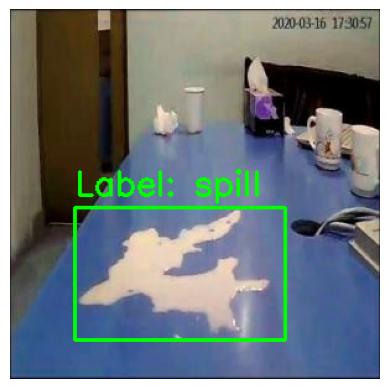

Raw image array shape: (299, 299, 3)
Bounding box coordinates: [52, 160, 222, 267]
Label: 4 (spill)
Label Mapping: {'waste': 0, 'home_object': 1, 'pet': 2, 'person': 3, 'spill': 4, 'dirt': 5}


In [17]:
# Ensure file_count is the length of x
file_count = len(x)

# Extract random image and the corresponding bounding box coordinates
num = random.randint(0, file_count - 1)  # Adjusted to prevent out-of-bounds error
img_example = x[num]
bbox = y[num][1:]  # Bounding box coordinates from the first annotation
label = y[num][0]  # The label of the image
label_name = reverse_label_mapping[label]

def visualize_image_with_bbox(img, bbox, label, label_name):
    # Draw the bounding box on the image
    xmin, ymin, xmax, ymax = bbox
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
    cv2.putText(img, 'Label: {}'.format(label_name), (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Convert BGR to RGB for matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

    # Print raw data for inspection
    print(f"Raw image array shape: {img.shape}")
    print(f"Bounding box coordinates: {bbox}")
    print(f"Label: {label} ({label_name})")
    print("Label Mapping:", label_mapping)

# Visualize the image with the bounding box
visualize_image_with_bbox(img_example, bbox, label, label_name)


split into train, test numpy arrays

In [18]:
# Convert lists to NumPy arrays
x = np.array(x)  # Convert list of images to numpy array
y = np.array(y)  # Convert list of labels to numpy array

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=21)

# Check the shapes of the split data
print(f"x_train shape: {x_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (2132, 299, 299, 3)
x_test shape: (533, 299, 299, 3)
y_train shape: (2132, 5)
y_test shape: (533, 5)


In [19]:
# Assuming y is structured as [label, xmin, ymin, xmax, ymax]
labels = [entry[0] for entry in y]  # Extracting only the class labels
label_counts = Counter(labels)

print("Label counts:", label_counts)
print("Total samples in y:", len(y))


Label counts: Counter({np.int64(1): 816, np.int64(0): 747, np.int64(2): 403, np.int64(3): 349, np.int64(4): 300, np.int64(5): 50})
Total samples in y: 2665


split data into separate categorical and boundary box sectors

In [20]:
categ_train = y_train[:, 0]  # Take the first column for training categories
categ_test = y_test[:, 0]    # Take the first column for testing categories
bbox_train = y_train[:, 1:]   # Take the remaining columns for training bounding boxes
bbox_test = y_test[:, 1:]     # Take the remaining columns for testing bounding boxes

# Print shapes to verify
print(f"categ_train shape: {categ_train.shape}")
print(f"categ_test shape: {categ_test.shape}")
print(f"bbox_train shape: {bbox_train.shape}")
print(f"bbox_test shape: {bbox_test.shape}")

# Convert category labels to one-hot encoded vectors
categ_train = tf.keras.utils.to_categorical(categ_train.astype(int), num_classes=num_classes)
categ_test = tf.keras.utils.to_categorical(categ_test.astype(int), num_classes=num_classes)

# Print shapes after one-hot encoding
print(f"One-hot encoded categ_train shape: {categ_train.shape}")
print(f"One-hot encoded categ_test shape: {categ_test.shape}")

categ_train shape: (2132,)
categ_test shape: (533,)
bbox_train shape: (2132, 4)
bbox_test shape: (533, 4)
One-hot encoded categ_train shape: (2132, 6)
One-hot encoded categ_test shape: (533, 6)


Loading the YOLO model with custom layers

---



In [23]:
# YOLO Training Script - Fixed Version

# Import required libraries
import os
import glob
import xml.etree.ElementTree as ET
import shutil
import random
import numpy as np

# Install ultralytics if needed
!pip install ultralytics

from ultralytics import YOLO

# Create directories for YOLO format
os.makedirs('/content/yolo_dataset/train/images', exist_ok=True)
os.makedirs('/content/yolo_dataset/train/labels', exist_ok=True)
os.makedirs('/content/yolo_dataset/valid/images', exist_ok=True)
os.makedirs('/content/yolo_dataset/valid/labels', exist_ok=True)
os.makedirs('/content/models', exist_ok=True)

# Define class mapping
class_mapping = {
    'waste': 0,
    'home_object': 1,
    'pet': 2,
    'person': 3,
    'spill': 4,
    'dirt': 5
}

# Let's inspect a sample XML file first to understand its structure
sample_xml = glob.glob('/content/cleaning_bot_object_dataset/xmls/*.xml')[0]
print(f"Inspecting sample XML file: {sample_xml}")
with open(sample_xml, 'r') as f:
    print(f.read()[:500] + '...')  # Print first 500 chars to see structure

# Function to convert XML to YOLO format - improved with better error handling
def convert_xml_to_yolo(xml_file, image_width=299, image_height=299):
    try:
        tree = ET.parse(xml_file)
        root = tree.getroot()

        # Check if root has the expected structure
        print(f"XML file: {xml_file}, Root tag: {root.tag}")

        # Check if size is specified in the XML
        size_element = root.find('.//size')
        if size_element is not None:
            width_element = size_element.find('width')
            height_element = size_element.find('height')
            if width_element is not None and height_element is not None:
                image_width = int(width_element.text)
                image_height = int(height_element.text)

        # Debug info
        print(f"Image dimensions: {image_width}x{image_height}")

        yolo_lines = []

        # Find all objects directly under the root or in a nested structure
        objects = root.findall('.//objects/*') or root.findall('.//object')
        if not objects:
            print(f"Warning: No objects found in {xml_file}")
            # Try different xpath patterns
            objects = root.findall('.//objects')
            if objects:
                print(f"Found {len(objects)} objects using alternative xpath")

        print(f"Found {len(objects)} objects")

        for obj in objects:
            # Try different patterns for finding the class name
            class_name = None
            name_element = obj.find('name')
            if name_element is not None:
                class_name = name_element.text

            if class_name is None:
                print(f"Warning: Could not find class name in object")
                continue

            if class_name not in class_mapping:
                print(f"Warning: Unknown class '{class_name}' - skipping")
                continue

            class_id = class_mapping[class_name]

            # Find bounding box (try different patterns)
            bbox = obj.find('bndbox')
            if bbox is None:
                print(f"Warning: No bounding box found for {class_name}")
                continue

            # Try to get coordinates
            try:
                xmin = float(bbox.find('xmin').text)
                ymin = float(bbox.find('ymin').text)
                xmax = float(bbox.find('xmax').text)
                ymax = float(bbox.find('ymax').text)

                # Validate coordinates
                if xmin >= xmax or ymin >= ymax:
                    print(f"Warning: Invalid bbox: {xmin}, {ymin}, {xmax}, {ymax}")
                    continue

                # Convert to YOLO format (center_x, center_y, width, height) - normalized
                center_x = ((xmin + xmax) / 2) / image_width
                center_y = ((ymin + ymax) / 2) / image_height
                width = (xmax - xmin) / image_width
                height = (ymax - ymin) / image_height

                # Ensure values are between 0 and 1
                center_x = max(0, min(1, center_x))
                center_y = max(0, min(1, center_y))
                width = max(0, min(1, width))
                height = max(0, min(1, height))

                yolo_line = f"{class_id} {center_x:.6f} {center_y:.6f} {width:.6f} {height:.6f}"
                print(f"Converted: {class_name} -> {yolo_line}")
                yolo_lines.append(yolo_line)
            except (AttributeError, ValueError) as e:
                print(f"Error parsing bbox: {e}")

        return yolo_lines
    except Exception as e:
        print(f"Error processing {xml_file}: {e}")
        return []

# First process a single file to check if conversion works
sample_conversion = convert_xml_to_yolo(sample_xml)
print(f"Sample conversion result: {sample_conversion}")

# If sample conversion fails, try to debug
if not sample_conversion:
    print("\nXML conversion failed. Trying to identify the structure...")
    try:
        tree = ET.parse(sample_xml)
        root = tree.getroot()
        print(f"XML root tag: {root.tag}")
        print("Child elements:")
        for child in root:
            print(f" - {child.tag}")
        print("\nTrying to find objects:")
        for path in ['.//objects/*', './/object', './/objects', './objects', './object']:
            objects = root.findall(path)
            print(f"Path '{path}': {len(objects)} objects found")
            if objects:
                print(f"First object tags: {[e.tag for e in objects[0]]}")
    except Exception as e:
        print(f"Debug error: {e}")

# Get all XML files
xml_files = glob.glob('/content/cleaning_bot_object_dataset/xmls/*.xml')
print(f"Total XML files found: {len(xml_files)}")

# Only proceed if we have successful conversion
if sample_conversion:
    random.seed(42)  # For reproducibility
    random.shuffle(xml_files)

    # Split into train and validation (80/20)
    split_idx = int(len(xml_files) * 0.8)
    train_xml_files = xml_files[:split_idx]
    valid_xml_files = xml_files[split_idx:]

    print(f"Training XMLs: {len(train_xml_files)}")
    print(f"Validation XMLs: {len(valid_xml_files)}")

    # Process training files
    processed_train = 0
    successful_train = 0
    for xml_file in train_xml_files:
        basename = os.path.basename(xml_file)
        image_name = basename.replace('.xml', '.jpg')

        # Copy image
        source_image = f'/content/cleaning_bot_object_dataset/images/{image_name}'
        if os.path.exists(source_image):
            shutil.copy(source_image, f'/content/yolo_dataset/train/images/{image_name}')
            processed_train += 1

            # Convert annotation
            yolo_lines = convert_xml_to_yolo(xml_file)
            if yolo_lines:
                with open(f'/content/yolo_dataset/train/labels/{image_name.replace(".jpg", ".txt")}', 'w') as f:
                    f.write('\n'.join(yolo_lines))
                successful_train += 1

    # Process validation files
    processed_valid = 0
    successful_valid = 0
    for xml_file in valid_xml_files:
        basename = os.path.basename(xml_file)
        image_name = basename.replace('.xml', '.jpg')

        # Copy image
        source_image = f'/content/cleaning_bot_object_dataset/images/{image_name}'
        if os.path.exists(source_image):
            shutil.copy(source_image, f'/content/yolo_dataset/valid/images/{image_name}')
            processed_valid += 1

            # Convert annotation
            yolo_lines = convert_xml_to_yolo(xml_file)
            if yolo_lines:
                with open(f'/content/yolo_dataset/valid/labels/{image_name.replace(".jpg", ".txt")}', 'w') as f:
                    f.write('\n'.join(yolo_lines))
                successful_valid += 1

    print(f"Processed {processed_train} training images, {successful_train} with successful conversions")
    print(f"Processed {processed_valid} validation images, {successful_valid} with successful conversions")

    # Create YAML configuration file
    with open('/content/yolo_dataset/data.yaml', 'w') as f:
        f.write(f"""
path: /content/yolo_dataset
train: train/images
val: valid/images

nc: 6
names: ['waste', 'home_object', 'pet', 'person', 'spill', 'dirt']
        """)

    print("Created data.yaml configuration file")

    # Only train if we have successfully converted annotations
    if successful_train > 0 and successful_valid > 0:
        # Load a pre-trained YOLO model
        model = YOLO('yolov8n.pt')  # Nano version for memory efficiency

        # Set training parameters
        batch_size = 8
        learning_rate = 1e-4

        print("Starting training...")

        # Train the model
        results = model.train(
            data='/content/yolo_dataset/data.yaml',
            epochs=100,
            imgsz=640,
            batch=batch_size,
            patience=10,  # Early stopping
            save=True,
            project='/content/models',
            name='yolov8',
            pretrained=True,
            optimizer='Adam',
            lr0=learning_rate,
            lrf=0.01,
            warmup_epochs=3,
            cos_lr=True,
            task='detect'
        )

        print("Training complete. Best model saved at: /content/models/yolov8/weights/best.pt")

        # Validate the model
        metrics = model.val()
        print(f"Validation metrics: {metrics}")
    else:
        print("ERROR: No successful annotation conversions. Cannot train YOLO model.")
else:
    print("Failed to convert XML to YOLO format. Cannot proceed with training.")

Streaming output truncated to the last 5000 lines.
Image dimensions: 299x299
Found 1 objects
Converted: home_object -> 1 0.612040 0.351171 0.361204 0.695652
XML file: /content/cleaning_bot_object_dataset/xmls/Glass913_jpg.rf.1f07b7a28b49eee978dc8c7f786e8af8.xml, Root tag: annotation
Image dimensions: 299x299
Found 1 objects
Converted: waste -> 0 0.605351 0.441472 0.274247 0.301003
XML file: /content/cleaning_bot_object_dataset/xmls/dirtimage_44_jpg.rf.5b77689703fbc13565f3d314a00ae39a.xml, Root tag: annotation
Image dimensions: 299x299
Found 1 objects
Converted: dirt -> 5 0.494983 0.255853 0.187291 0.163880
XML file: /content/cleaning_bot_object_dataset/xmls/augmented_5107_WhatsApp-Image-2024-09-16-at-4-16-50-PM_jpeg.rf.2c960507b3ad7bb55e3a820758feb57d.xml, Root tag: annotation
Image dimensions: 299x299
Found 1 objects
Converted: spill -> 4 0.471572 0.790970 0.193980 0.190635
XML file: /content/cleaning_bot_object_dataset/xmls/91_jpg.rf.bc24153a0fe8433f8d60060dab71cdc4.xml, Root tag: an

train: Scanning /content/yolo_dataset/train/labels... 2132 images, 424 backgrounds, 0 corrupt: 100%|██████████| 2556/2556 [00:01<00:00, 2382.21it/s]

train: New cache created: /content/yolo_dataset/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.2±0.4 ms, read: 224.6±94.9 MB/s, size: 14.0 KB)


val: Scanning /content/yolo_dataset/valid/labels... 533 images, 424 backgrounds, 0 corrupt: 100%|██████████| 957/957 [00:00<00:00, 1317.26it/s]

val: New cache created: /content/yolo_dataset/valid/labels.cache


Plotting labels to /content/models/yolov83/labels.jpg... 
optimizer: Adam(lr=0.0001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/models/yolov83
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      5.98G      1.536      3.302      1.666         17        640: 100%|██████████| 320/320 [01:02<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:16<00:00,  3.72it/s]


                   all        957       1104      0.285      0.131     0.0621     0.0283

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      6.01G      1.462      2.682      1.606         10        640: 100%|██████████| 320/320 [00:57<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:08<00:00,  7.40it/s]


                   all        957       1104      0.428      0.254      0.184      0.103

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      6.03G       1.42      2.361        1.6         16        640: 100%|██████████| 320/320 [00:57<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:08<00:00,  7.37it/s]


                   all        957       1104      0.461      0.367      0.262      0.154

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      6.03G      1.381      2.166      1.551         19        640: 100%|██████████| 320/320 [00:56<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:08<00:00,  7.32it/s]

                   all        957       1104      0.431      0.368      0.283      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      6.03G      1.376      2.056      1.537          9        640: 100%|██████████| 320/320 [00:56<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:08<00:00,  7.36it/s]

                   all        957       1104      0.336      0.467      0.334      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      6.03G      1.338      1.991      1.515         12        640: 100%|██████████| 320/320 [00:56<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:08<00:00,  7.35it/s]

                   all        957       1104      0.321      0.579      0.352      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      6.03G      1.331      1.935      1.501          7        640: 100%|██████████| 320/320 [00:56<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:07<00:00,  8.03it/s]

                   all        957       1104      0.423       0.55      0.392       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      6.03G       1.32      1.861      1.489         20        640: 100%|██████████| 320/320 [00:56<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:06<00:00,  8.57it/s]

                   all        957       1104      0.415       0.58      0.411      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      6.04G      1.302      1.799      1.489         21        640: 100%|██████████| 320/320 [00:56<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:07<00:00,  8.40it/s]

                   all        957       1104      0.444      0.575      0.409      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      6.04G      1.304      1.761      1.472          4        640: 100%|██████████| 320/320 [00:55<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:08<00:00,  7.42it/s]

                   all        957       1104      0.433      0.591       0.43       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      6.04G      1.262      1.721      1.448         12        640: 100%|██████████| 320/320 [00:56<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:08<00:00,  7.18it/s]

                   all        957       1104      0.409      0.594       0.42      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      6.04G      1.281      1.674      1.461         16        640: 100%|██████████| 320/320 [00:55<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:12<00:00,  4.98it/s]

                   all        957       1104       0.43      0.564      0.419      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      6.04G      1.287      1.618      1.447         11        640: 100%|██████████| 320/320 [00:57<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:08<00:00,  7.38it/s]

                   all        957       1104      0.481       0.55      0.423      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      6.04G      1.268      1.602      1.437         12        640: 100%|██████████| 320/320 [00:56<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:08<00:00,  7.40it/s]

                   all        957       1104      0.466      0.585       0.44      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      6.04G      1.263      1.559      1.426          4        640: 100%|██████████| 320/320 [00:56<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:08<00:00,  7.40it/s]

                   all        957       1104      0.453      0.618      0.434      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      6.04G      1.264      1.587      1.435          6        640: 100%|██████████| 320/320 [00:58<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:08<00:00,  7.41it/s]

                   all        957       1104      0.448       0.65      0.439      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      6.04G      1.234      1.517      1.422          8        640: 100%|██████████| 320/320 [00:55<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:08<00:00,  7.42it/s]


                   all        957       1104      0.452       0.62      0.428      0.256

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      6.04G      1.281      1.554      1.447         12        640: 100%|██████████| 320/320 [00:57<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:07<00:00,  7.69it/s]

                   all        957       1104      0.453      0.615      0.437      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      6.06G      1.246      1.521      1.415          8        640: 100%|██████████| 320/320 [00:56<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:07<00:00,  8.46it/s]

                   all        957       1104      0.451      0.614      0.433      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      6.08G      1.254      1.502      1.429         21        640: 100%|██████████| 320/320 [00:56<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:06<00:00,  8.60it/s]

                   all        957       1104      0.442      0.589      0.423      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      6.09G      1.224       1.47      1.399          4        640: 100%|██████████| 320/320 [00:57<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:07<00:00,  8.31it/s]

                   all        957       1104      0.448      0.665       0.43      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      6.09G      1.238      1.461      1.409          6        640: 100%|██████████| 320/320 [00:55<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:08<00:00,  7.41it/s]

                   all        957       1104      0.415      0.655      0.432      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      6.11G      1.236      1.443      1.405         10        640: 100%|██████████| 320/320 [00:56<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:08<00:00,  7.34it/s]

                   all        957       1104      0.449      0.657      0.445      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      6.11G      1.189      1.409      1.387         12        640: 100%|██████████| 320/320 [00:55<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:07<00:00,  7.52it/s]

                   all        957       1104      0.448       0.64      0.433      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      6.11G      1.198      1.403      1.388         20        640: 100%|██████████| 320/320 [00:58<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:07<00:00,  7.53it/s]

                   all        957       1104       0.47      0.642      0.445      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      6.11G      1.198      1.383      1.395          7        640: 100%|██████████| 320/320 [00:55<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:07<00:00,  8.13it/s]


                   all        957       1104      0.433      0.669      0.428       0.26

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      6.11G      1.198      1.375       1.38          7        640: 100%|██████████| 320/320 [00:57<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:06<00:00,  8.66it/s]

                   all        957       1104      0.426      0.641      0.415       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      6.11G      1.186       1.36      1.359          9        640: 100%|██████████| 320/320 [00:56<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:07<00:00,  8.23it/s]

                   all        957       1104      0.449      0.648       0.43      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      6.11G      1.184      1.335      1.361         21        640: 100%|██████████| 320/320 [00:56<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:08<00:00,  7.24it/s]

                   all        957       1104      0.471      0.669      0.444       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      6.11G      1.187      1.328       1.37         11        640: 100%|██████████| 320/320 [00:56<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:08<00:00,  7.24it/s]

                   all        957       1104      0.437      0.675      0.434      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      6.11G      1.167      1.327      1.353          5        640: 100%|██████████| 320/320 [00:55<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:08<00:00,  7.37it/s]

                   all        957       1104      0.461      0.672      0.449      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      6.11G      1.189      1.317      1.367         16        640: 100%|██████████| 320/320 [00:55<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:07<00:00,  8.05it/s]


                   all        957       1104      0.458       0.69      0.431      0.259

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      6.11G       1.19      1.307      1.373         12        640: 100%|██████████| 320/320 [00:58<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:07<00:00,  7.89it/s]


                   all        957       1104      0.463      0.669      0.438      0.257

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      6.11G      1.147      1.254      1.335         20        640: 100%|██████████| 320/320 [00:57<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:07<00:00,  8.37it/s]

                   all        957       1104       0.44      0.704      0.432      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      6.11G      1.169      1.302      1.355          5        640: 100%|██████████| 320/320 [00:57<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:07<00:00,  8.29it/s]

                   all        957       1104      0.438      0.665      0.435      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      6.11G      1.163      1.262      1.348         12        640: 100%|██████████| 320/320 [00:54<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:08<00:00,  7.25it/s]

                   all        957       1104       0.47      0.665      0.443      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      6.11G      1.154      1.236      1.338         12        640: 100%|██████████| 320/320 [00:55<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:08<00:00,  7.29it/s]

                   all        957       1104      0.456      0.642      0.416       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      6.11G      1.157      1.253      1.348          7        640: 100%|██████████| 320/320 [00:55<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:07<00:00,  8.51it/s]


                   all        957       1104       0.47      0.667      0.439       0.26

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      6.11G      1.139      1.227      1.339          5        640: 100%|██████████| 320/320 [00:55<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:08<00:00,  7.40it/s]

                   all        957       1104      0.443      0.676      0.424      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      6.11G      1.147      1.231      1.336          9        640: 100%|██████████| 320/320 [00:57<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:06<00:00,  8.83it/s]

                   all        957       1104      0.446      0.694      0.424      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      6.11G      1.114      1.218      1.323         10        640: 100%|██████████| 320/320 [00:54<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:07<00:00,  7.52it/s]

                   all        957       1104      0.453      0.702       0.43      0.265
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 31, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



41 epochs completed in 0.743 hours.
Optimizer stripped from /content/models/yolov83/weights/last.pt, 6.2MB
Optimizer stripped from /content/models/yolov83/weights/best.pt, 6.2MB

Validating /content/models/yolov83/weights/best.pt...
Ultralytics 8.3.113 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:09<00:00,  6.25it/s]


                   all        957       1104      0.462      0.669      0.448      0.273
                 waste        136        381       0.31       0.36      0.221      0.118
           home_object        161        367      0.416      0.452      0.323       0.21
                   pet         89        145      0.567       0.73       0.54      0.318
                person         74        111      0.461      0.802      0.468      0.281
                 spill         59         79      0.446      0.861      0.486      0.297
                  dirt         14         21       0.57       0.81      0.649      0.411
Speed: 0.5ms preprocess, 2.6ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to /content/models/yolov83
Training complete. Best model saved at: /content/models/yolov8/weights/best.pt
Ultralytics 8.3.113 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs
val: Fast im

val: Scanning /content/yolo_dataset/valid/labels.cache... 533 images, 424 backgrounds, 0 corrupt: 100%|██████████| 957/957 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 120/120 [00:10<00:00, 11.75it/s]


                   all        957       1104      0.462      0.672      0.449      0.274
                 waste        136        381      0.309      0.362       0.22      0.118
           home_object        161        367      0.414      0.452      0.323       0.21
                   pet         89        145      0.567      0.732      0.541      0.319
                person         74        111      0.465      0.813       0.47      0.281
                 spill         59         79      0.445      0.861      0.485      0.296
                  dirt         14         21       0.57       0.81      0.658      0.419
Speed: 0.7ms preprocess, 4.3ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to /content/models/yolov832
Validation metrics: ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x788ee030fb9

Searching for any CSV files in the models directories...
Found 1 CSV files:
 - /content/models/yolov83/results.csv

Contents of first CSV file:
   epoch     time  train/box_loss  train/cls_loss  train/dfl_loss  \
0      1   79.280         1.53595         3.30167         1.66584   
1      2  145.701         1.46167         2.68230         1.60608   
2      3  211.937         1.42044         2.36114         1.60022   
3      4  276.640         1.38052         2.16559         1.55091   
4      5  342.020         1.37563         2.05557         1.53678   

   metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
0               0.28537            0.13079           0.06214   
1               0.42795            0.25419           0.18351   
2               0.46091            0.36723           0.26176   
3               0.43149            0.36845           0.28301   
4               0.33604            0.46712           0.33410   

   metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/

val: Scanning /content/yolo_dataset/valid/labels.cache... 533 images, 424 backgrounds, 0 corrupt: 100%|██████████| 957/957 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:09<00:00,  6.13it/s]


                   all        957       1104      0.462      0.672      0.449      0.274
                 waste        136        381      0.309      0.362       0.22      0.118
           home_object        161        367      0.414      0.452      0.323       0.21
                   pet         89        145      0.567      0.732      0.541      0.319
                person         74        111      0.465      0.813       0.47      0.281
                 spill         59         79      0.445      0.861      0.485      0.296
                  dirt         14         21       0.57       0.81      0.658      0.419
Speed: 0.6ms preprocess, 3.9ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/val

Model evaluation results:
   metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
0              0.461747           0.671578          0.449439   

   metrics/mAP50-95(B)   fitness  
0             0.273983  0.291529  

Results saved to: /content/yolo_mod

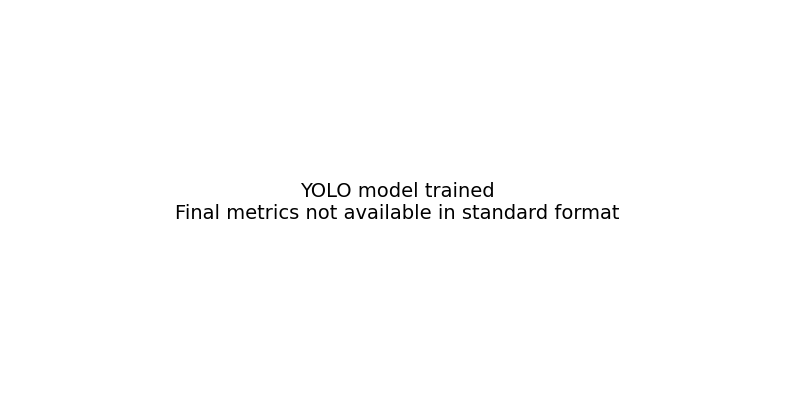

In [31]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt

# Step 1: Search more deeply for any CSV files
print("Searching for any CSV files in the models directories...")
csv_files = glob.glob('/content/models/**/*.csv', recursive=True)

if csv_files:
    print(f"Found {len(csv_files)} CSV files:")
    for file in csv_files:
        print(f" - {file}")

    # Try to use the first CSV file found
    results_df = pd.read_csv(csv_files[0])
    print("\nContents of first CSV file:")
    print(results_df.head())
else:
    print("No CSV files found.")

# Step 2: Check for other result files (like .txt or .yaml)
print("\nSearching for any other potential result files...")
result_files = glob.glob('/content/models/**/*result*.*', recursive=True)
result_files += glob.glob('/content/models/**/training_*.txt', recursive=True)

if result_files:
    print(f"Found {len(result_files)} potential result files:")
    for file in result_files:
        print(f" - {file}")
else:
    print("No other result files found.")

# Step 3: If no CSV file is found, let's check what files are actually available
print("\nListing files in YOLO directories:")
!find /content/models/yolov8 -type f | sort

# Step 4: If we can't find results files, create a simple results table
print("\nCreating a simple results summary from the available information...")

# Try to load the model if it exists
try:
    from ultralytics import YOLO

    # Check each directory for the best model
    model_paths = []
    for directory in ['/content/models/yolov8/weights', '/content/models/yolov82/weights',
                     '/content/models/yolov83/weights', '/content/models/yolov832/weights']:
        if os.path.exists(os.path.join(directory, 'best.pt')):
            model_paths.append(os.path.join(directory, 'best.pt'))

    if model_paths:
        print(f"Found {len(model_paths)} model weight files")

        # Load the first model found
        model = YOLO(model_paths[0])

        # Evaluate on validation set if available
        if os.path.exists('/content/yolo_dataset/valid/images'):
            print("Evaluating model on validation data...")
            metrics = model.val(data='/content/yolo_dataset/data.yaml')

            # Create a simple DataFrame with the metrics
            metrics_dict = {}

            # Extract metrics
            if hasattr(metrics, 'results_dict'):
                metrics_dict = metrics.results_dict
            elif hasattr(metrics, 'box') and metrics.box is not None:
                metrics_dict = {
                    'precision': metrics.box.results_dict.get('metrics/precision(B)', 0),
                    'recall': metrics.box.results_dict.get('metrics/recall(B)', 0),
                    'mAP50': metrics.box.results_dict.get('metrics/mAP50(B)', 0),
                    'mAP50-95': metrics.box.results_dict.get('metrics/mAP50-95(B)', 0)
                }

            # Create a simple results DataFrame
            results_df = pd.DataFrame([metrics_dict])
            print("\nModel evaluation results:")
            print(results_df)

            # Save to Excel
            results_df.to_excel('/content/yolo_model_results.xlsx', index=False)
            print("\nResults saved to: /content/yolo_model_results.xlsx")
        else:
            print("Validation data directory not found")
    else:
        print("No model weight files found")

except Exception as e:
    print(f"Error accessing model: {e}")

# Create a simple graph showing model architecture if metrics not available
print("\nCreating a simple model graph if results not available...")
try:
    # Generate a basic model graph
    plt.figure(figsize=(10, 5))
    plt.text(0.5, 0.5, "YOLO model trained\nFinal metrics not available in standard format",
             horizontalalignment='center', verticalalignment='center', fontsize=14)
    plt.axis('off')
    plt.savefig('/content/yolo_model_summary.png')
    print("Basic model summary image saved to: /content/yolo_model_summary.png")
except Exception as e:
    print(f"Error creating summary: {e}")

In [35]:
import csv

with open('/content/models/yolov83/results.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    header = next(csv_reader)

print("List of column names:", header)


List of column names: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


YOLO results columns: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']
Total epochs: 41

First few rows:
   epoch     time  train/box_loss  train/cls_loss  train/dfl_loss  \
0      1   79.280         1.53595         3.30167         1.66584   
1      2  145.701         1.46167         2.68230         1.60608   
2      3  211.937         1.42044         2.36114         1.60022   
3      4  276.640         1.38052         2.16559         1.55091   
4      5  342.020         1.37563         2.05557         1.53678   

   metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
0               0.28537            0.13079           0.06214   
1               0.42795            0.25419           0.18351   
2               0.46091            0.36723           0.26176   
3               0.43149            

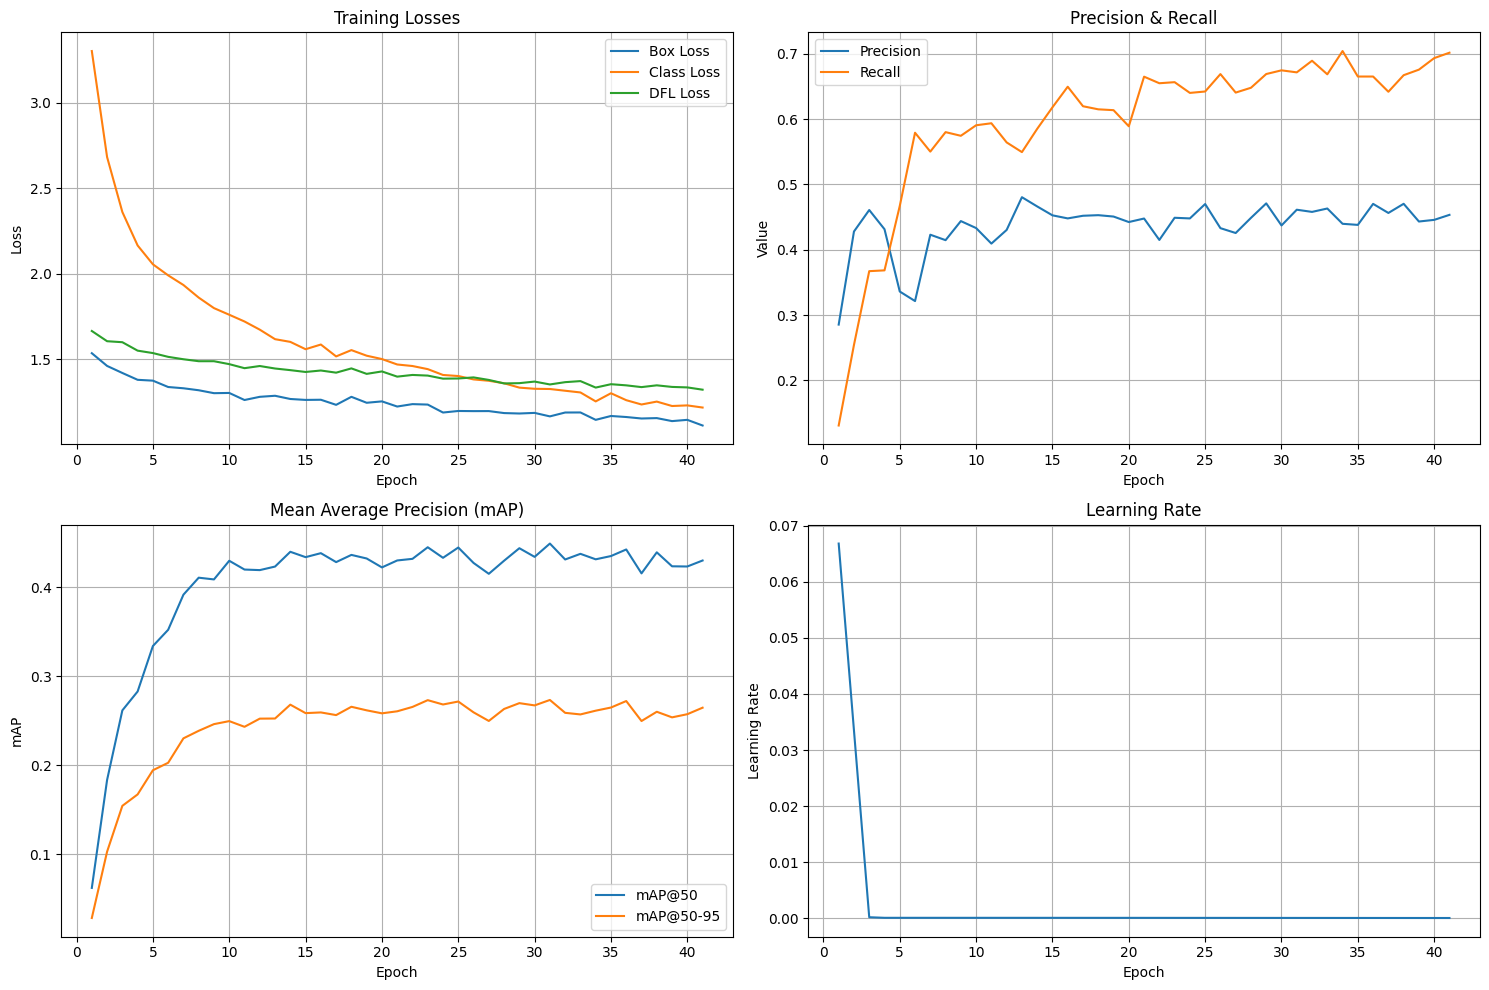


Training metrics visualization saved to: /content/yolo_training_metrics.png

Creating standardized metrics for comparison with other models...
Standardized metrics saved to: /content/yolo_standardized_metrics.xlsx


In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the YOLO results file
yolo_results_path = '/content/models/yolov83/results.csv'
df = pd.read_csv(yolo_results_path)

# Display basic info about the dataframe
print("YOLO results columns:", df.columns.tolist())
print("Total epochs:", len(df))
print("\nFirst few rows:")
print(df.head())

# Select rows for every 5 epochs (similar to your original code)
milestone_epochs = df.iloc[::5]  # Every 5th row
print("\nMilestone epochs (every 5th epoch):")
print(milestone_epochs)

# Save full results to Excel
df.to_excel('/content/yolo_model_results.xlsx', index=False)
print(f"\nFull results saved to: /content/yolo_model_results.xlsx")

# Save milestone epochs to Excel
milestone_epochs.to_excel('/content/yolo_milestone_epochs.xlsx', index=False)
print(f"Milestone epochs saved to: /content/yolo_milestone_epochs.xlsx")

# Create visualization of key metrics
plt.figure(figsize=(15, 10))

# Plot 1: Training losses
plt.subplot(2, 2, 1)
if 'train/box_loss' in df.columns:
    plt.plot(df['epoch'], df['train/box_loss'], label='Box Loss')
if 'train/cls_loss' in df.columns:
    plt.plot(df['epoch'], df['train/cls_loss'], label='Class Loss')
if 'train/dfl_loss' in df.columns:
    plt.plot(df['epoch'], df['train/dfl_loss'], label='DFL Loss')
plt.title('Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Validation metrics
plt.subplot(2, 2, 2)
if 'metrics/precision(B)' in df.columns:
    plt.plot(df['epoch'], df['metrics/precision(B)'], label='Precision')
if 'metrics/recall(B)' in df.columns:
    plt.plot(df['epoch'], df['metrics/recall(B)'], label='Recall')
plt.title('Precision & Recall')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# Plot 3: mAP metrics
plt.subplot(2, 2, 3)
if 'metrics/mAP50(B)' in df.columns:
    plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@50')
if 'metrics/mAP50-95(B)' in df.columns:
    plt.plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP@50-95')
plt.title('Mean Average Precision (mAP)')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.legend()
plt.grid(True)

# Plot 4: Learning rate
plt.subplot(2, 2, 4)
if 'lr/pg0' in df.columns:
    plt.plot(df['epoch'], df['lr/pg0'], label='Learning Rate')
plt.title('Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)

plt.tight_layout()
plt.savefig('/content/yolo_training_metrics.png')
plt.show()

print(f"\nTraining metrics visualization saved to: /content/yolo_training_metrics.png")

# Optional: Convert the YOLO metrics to a format similar to your other models
# This can help with consistent comparison between models
print("\nCreating standardized metrics for comparison with other models...")

# Create a standardized DataFrame with common metrics
standard_metrics = pd.DataFrame()
standard_metrics['epoch'] = df['epoch']

# Map YOLO metrics to standardized names
if 'train/box_loss' in df.columns:
    standard_metrics['bbox_loss'] = df['train/box_loss']
if 'train/cls_loss' in df.columns:
    standard_metrics['classification_loss'] = df['train/cls_loss']
if 'metrics/precision(B)' in df.columns:
    standard_metrics['precision'] = df['metrics/precision(B)']
if 'metrics/recall(B)' in df.columns:
    standard_metrics['recall'] = df['metrics/recall(B)']
if 'metrics/mAP50(B)' in df.columns:
    standard_metrics['mAP50'] = df['metrics/mAP50(B)']
if 'metrics/mAP50-95(B)' in df.columns:
    standard_metrics['mAP'] = df['metrics/mAP50-95(B)']

# Save standardized metrics
standard_metrics.to_excel('/content/yolo_standardized_metrics.xlsx', index=False)
print("Standardized metrics saved to: /content/yolo_standardized_metrics.xlsx")

Visualizing Results

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir ./logs

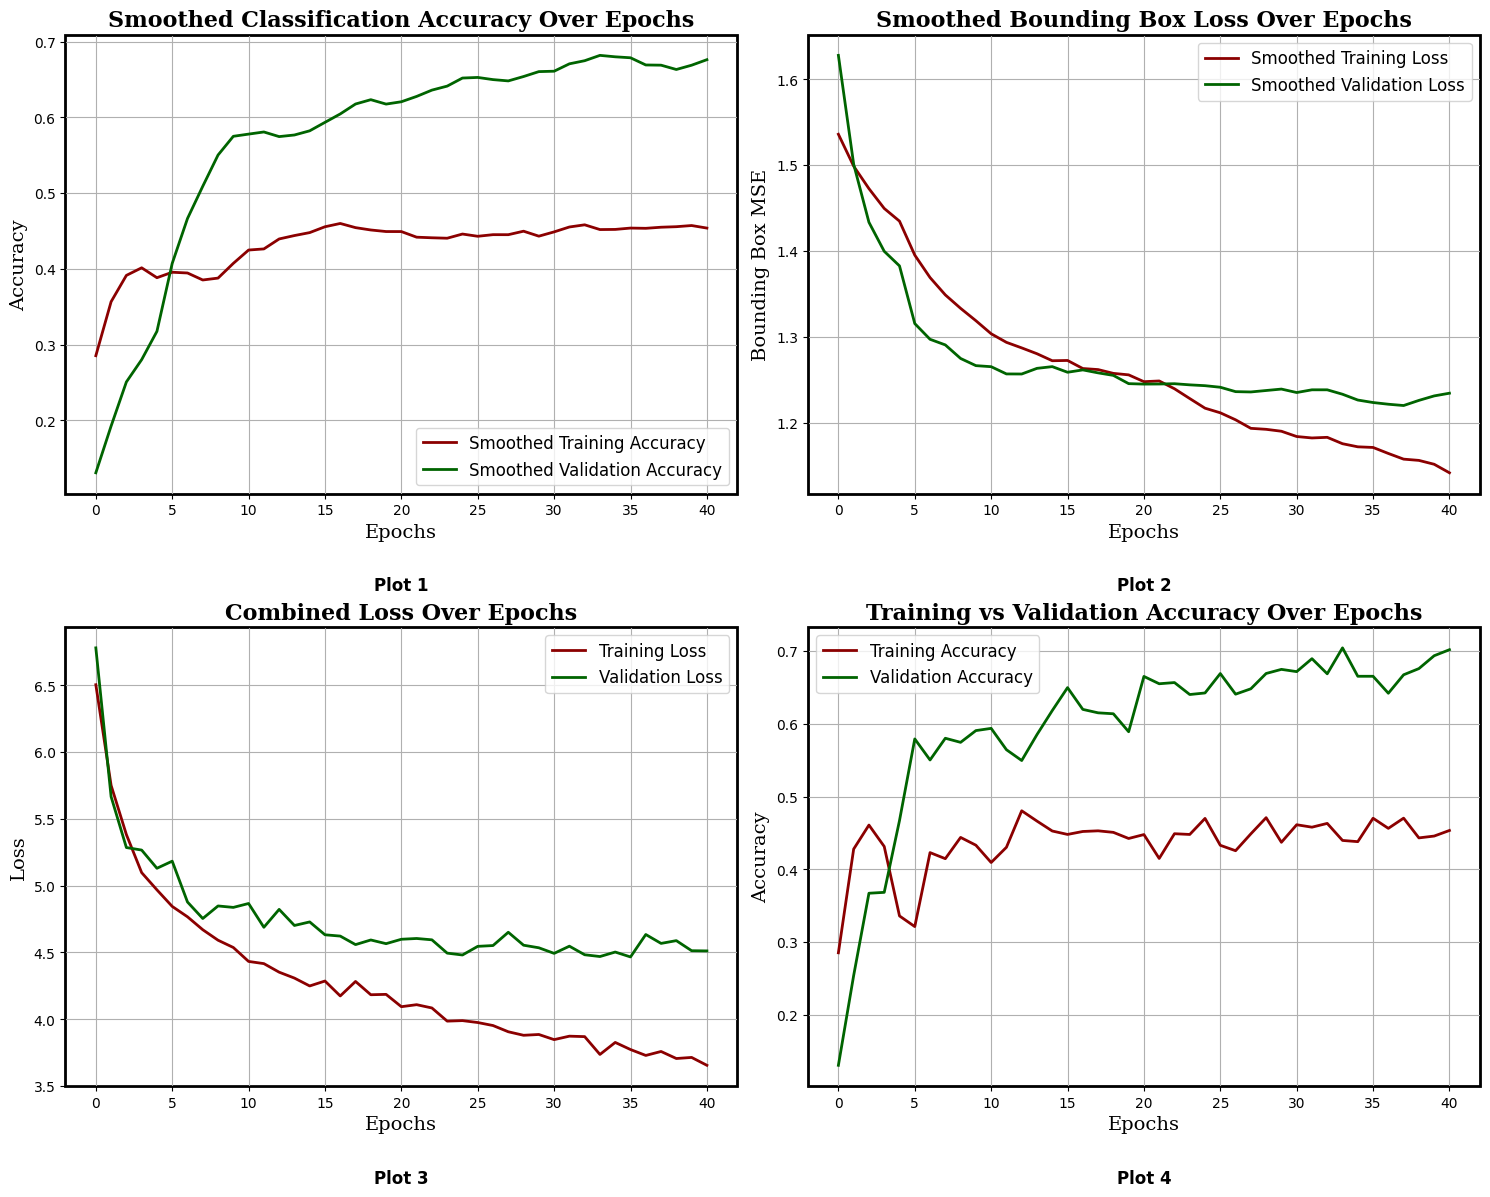

Visualization saved to: /content/yolo_training_visualization.png


In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the YOLO data from the CSV file
file_path = '/content/models/yolov83/results.csv'
results = pd.read_csv(file_path)

# Smoothing function (moving average)
def smooth(series, window_size=5):
    return series.rolling(window=window_size, min_periods=1).mean()

# Map YOLO metrics to expected column names
results['classification_accuracy'] = results['metrics/precision(B)']
results['val_classification_accuracy'] = results['metrics/recall(B)']
results['bounding_box_mse'] = results['train/box_loss']
results['val_bounding_box_mse'] = results['val/box_loss']

# Calculate combined losses
results['loss'] = results[['train/box_loss', 'train/cls_loss', 'train/dfl_loss']].sum(axis=1)
results['val_loss'] = results[['val/box_loss', 'val/cls_loss', 'val/dfl_loss']].sum(axis=1)

# Add smoothed columns exactly as requested
results['smooth_classification_accuracy'] = smooth(results['classification_accuracy'])
results['smooth_val_classification_accuracy'] = smooth(results['val_classification_accuracy'])
results['smooth_bounding_box_mse'] = smooth(results['bounding_box_mse'])
results['smooth_val_bounding_box_mse'] = smooth(results['val_bounding_box_mse'])

# Create a figure with 2 rows and 2 columns for subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))  # 2x2 grid of plots

# Define a function to add a border to the subplots
def add_border(ax):
    ax.patch.set_edgecolor('black')
    ax.patch.set_linewidth(2)

# 1. Smoothed Classification Accuracy
axes[0, 0].plot(results['smooth_classification_accuracy'], label='Smoothed Training Accuracy', color='#8B0000', linewidth=2)
axes[0, 0].plot(results['smooth_val_classification_accuracy'], label='Smoothed Validation Accuracy', color='#006400', linewidth=2)
axes[0, 0].set_title('Smoothed Classification Accuracy Over Epochs', fontsize=16, fontweight='bold', fontname='DejaVu Serif')
axes[0, 0].set_xlabel('Epochs', fontsize=14, fontname='DejaVu Serif')
axes[0, 0].set_ylabel('Accuracy', fontsize=14, fontname='DejaVu Serif')
axes[0, 0].legend(loc='best', fontsize=12)
axes[0, 0].grid(True)
add_border(axes[0, 0])
axes[0, 0].text(0.5, -0.2, 'Plot 1', ha='center', va='center', fontsize=12, fontweight='bold', transform=axes[0, 0].transAxes)

# 2. Smoothed Bounding Box Loss
axes[0, 1].plot(results['smooth_bounding_box_mse'], label='Smoothed Training Loss', color='#8B0000', linewidth=2)
axes[0, 1].plot(results['smooth_val_bounding_box_mse'], label='Smoothed Validation Loss', color='#006400', linewidth=2)
axes[0, 1].set_title('Smoothed Bounding Box Loss Over Epochs', fontsize=16, fontweight='bold', fontname='DejaVu Serif')
axes[0, 1].set_xlabel('Epochs', fontsize=14, fontname='DejaVu Serif')
axes[0, 1].set_ylabel('Bounding Box MSE', fontsize=14, fontname='DejaVu Serif')
axes[0, 1].legend(loc='best', fontsize=12)
axes[0, 1].grid(True)
add_border(axes[0, 1])
axes[0, 1].text(0.5, -0.2, 'Plot 2', ha='center', va='center', fontsize=12, fontweight='bold', transform=axes[0, 1].transAxes)

# 3. Combined Loss
axes[1, 0].plot(results['loss'], label='Training Loss', color='#8B0000', linewidth=2)
axes[1, 0].plot(results['val_loss'], label='Validation Loss', color='#006400', linewidth=2)
axes[1, 0].set_title('Combined Loss Over Epochs', fontsize=16, fontweight='bold', fontname='DejaVu Serif')
axes[1, 0].set_xlabel('Epochs', fontsize=14, fontname='DejaVu Serif')
axes[1, 0].set_ylabel('Loss', fontsize=14, fontname='DejaVu Serif')
axes[1, 0].legend(loc='best', fontsize=12)
axes[1, 0].grid(True)
add_border(axes[1, 0])
axes[1, 0].text(0.5, -0.2, 'Plot 3', ha='center', va='center', fontsize=12, fontweight='bold', transform=axes[1, 0].transAxes)

# 4. Training vs Validation Accuracy
axes[1, 1].plot(results['classification_accuracy'], label='Training Accuracy', color='#8B0000', linewidth=2)
axes[1, 1].plot(results['val_classification_accuracy'], label='Validation Accuracy', color='#006400', linewidth=2)
axes[1, 1].set_title('Training vs Validation Accuracy Over Epochs', fontsize=16, fontweight='bold', fontname='DejaVu Serif')
axes[1, 1].set_xlabel('Epochs', fontsize=14, fontname='DejaVu Serif')
axes[1, 1].set_ylabel('Accuracy', fontsize=14, fontname='DejaVu Serif')
axes[1, 1].legend(loc='best', fontsize=12)
axes[1, 1].grid(True)
add_border(axes[1, 1])
axes[1, 1].text(0.5, -0.2, 'Plot 4', ha='center', va='center', fontsize=12, fontweight='bold', transform=axes[1, 1].transAxes)

# Adjust layout to avoid overlap
plt.tight_layout()

# Save the figure
plt.savefig('/content/yolo_training_visualization.png', dpi=300, bbox_inches='tight')

# Show the entire figure
plt.show()

print("Visualization saved to: /content/yolo_training_visualization.png")

=== YOLO Generated Visualizations ===

Confusion Matrix (2 files found):
  - confusion_matrix_normalized.png


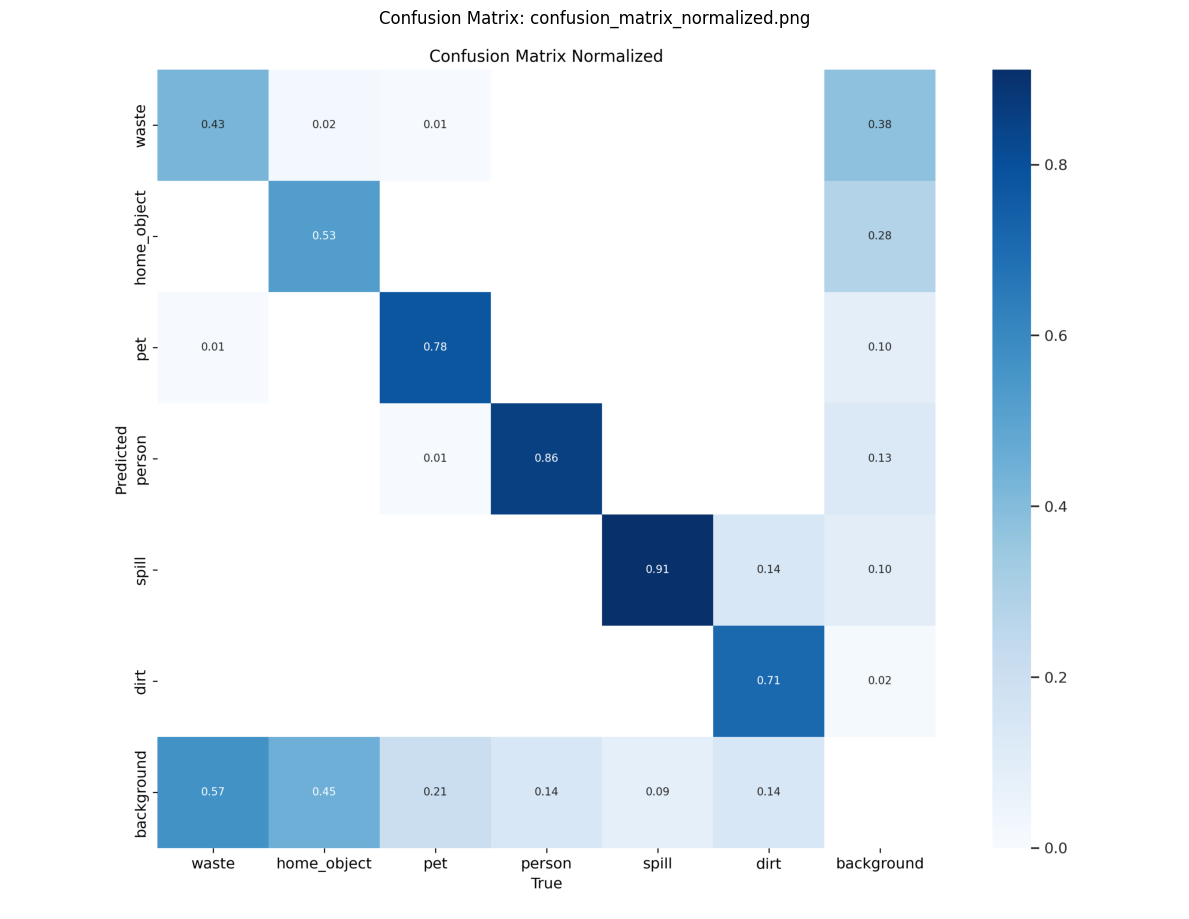

  - confusion_matrix.png


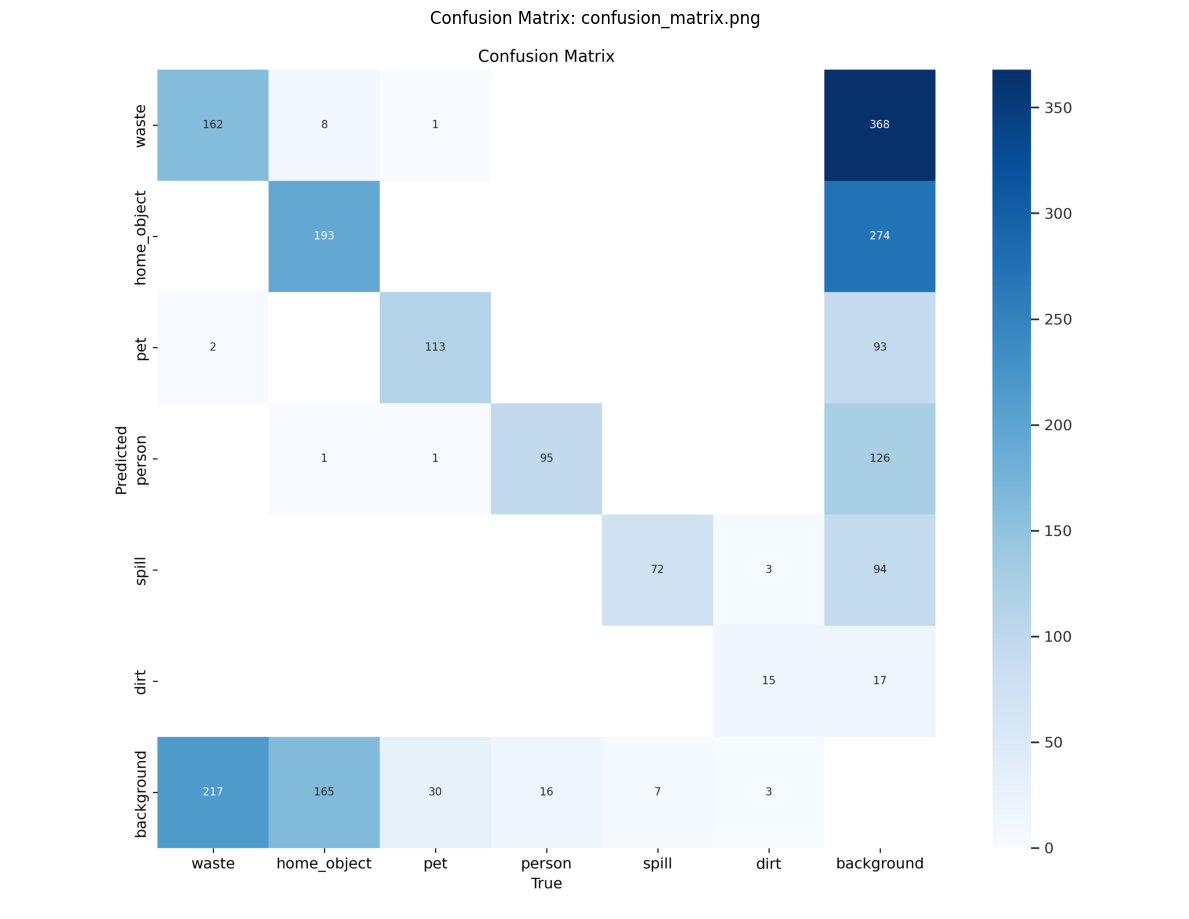


PR Curve (1 files found):
  - PR_curve.png


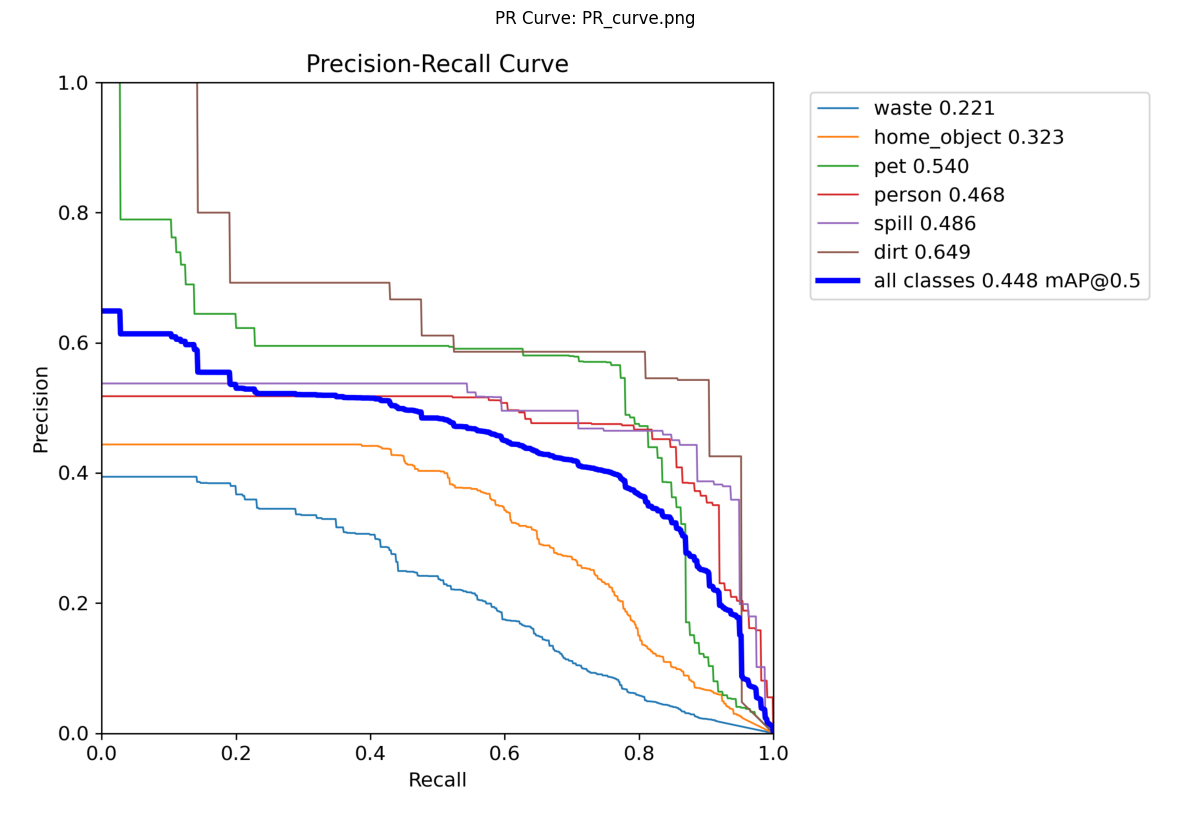


F1 Confidence (1 files found):
  - F1_curve.png


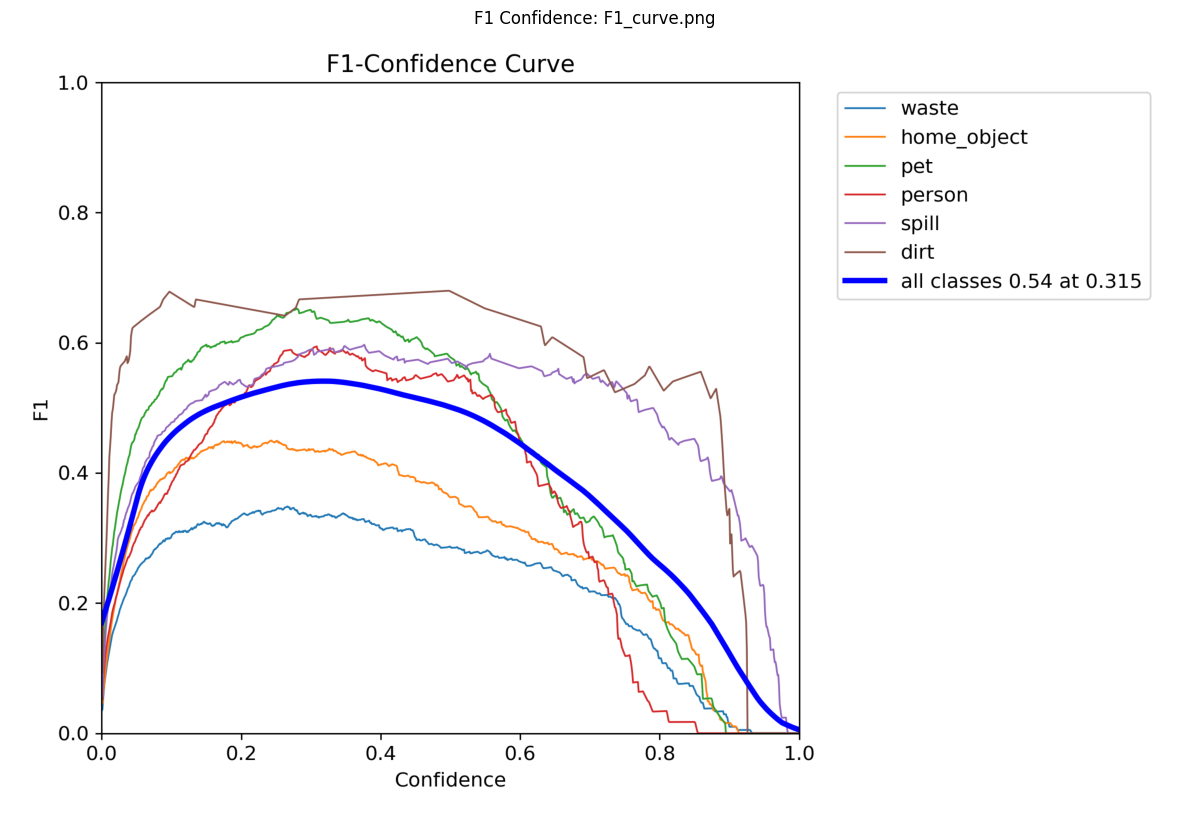


Results (1 files found):
  - results.png


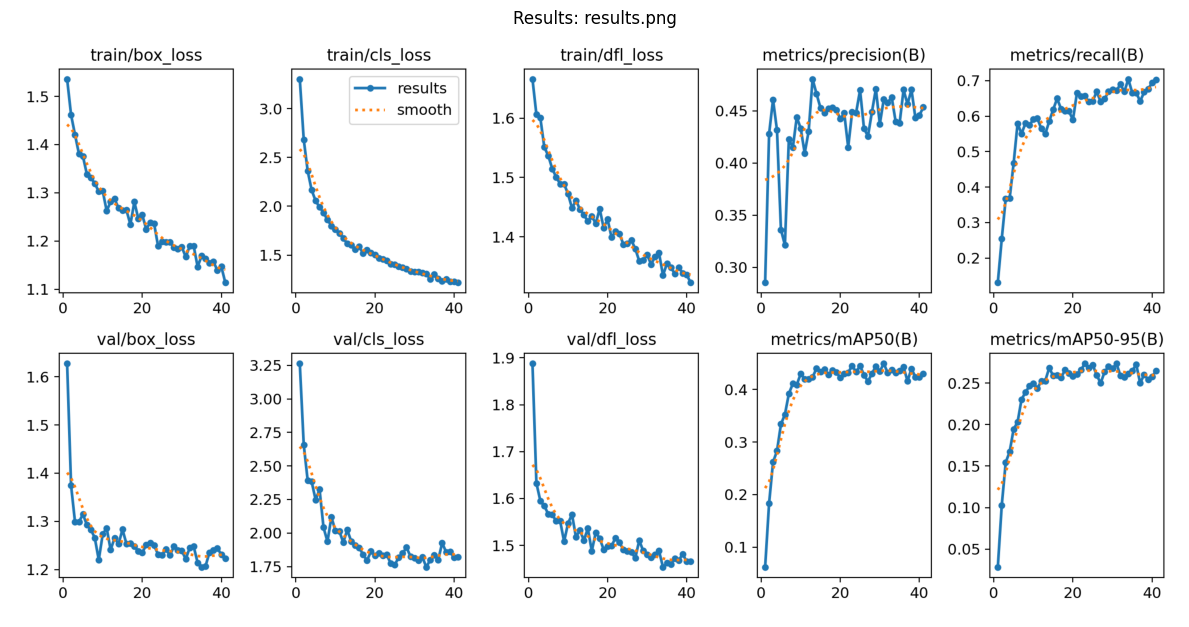


Val Batch Predictions (6 files found):
  - val_batch2_pred.jpg


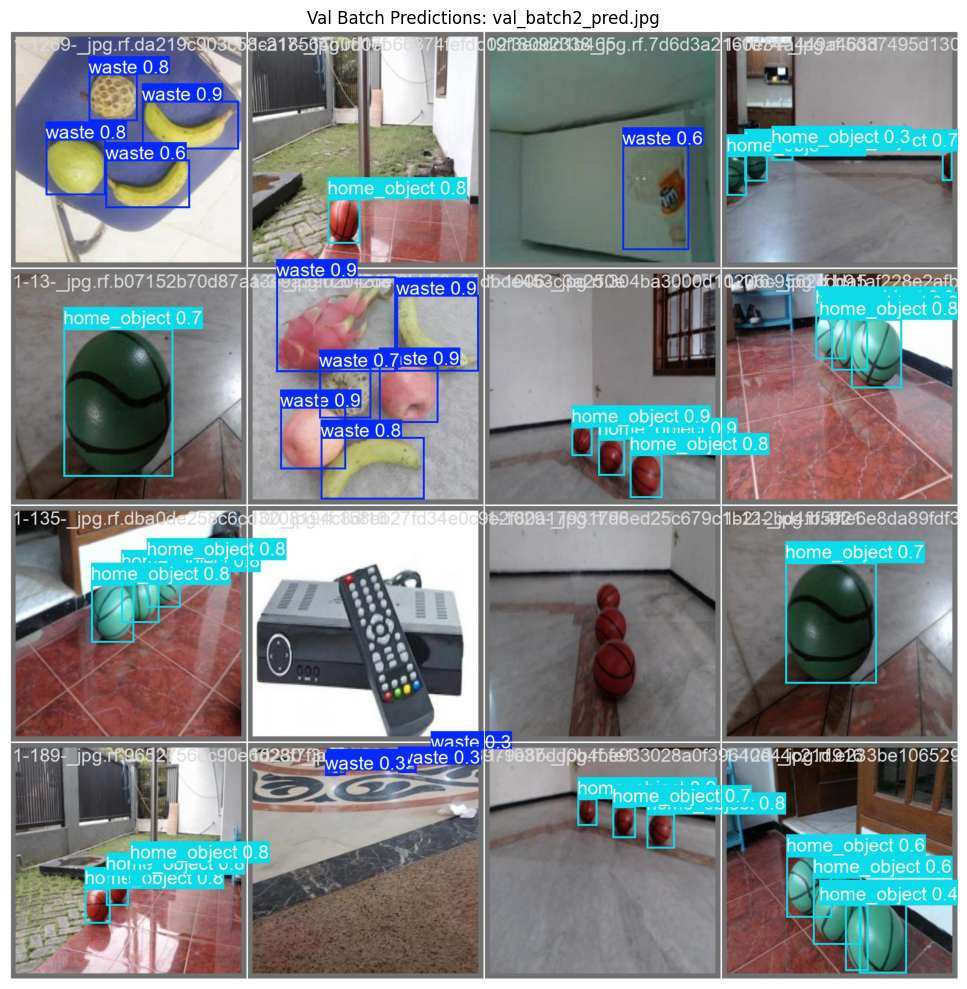

  - val_batch1_labels.jpg


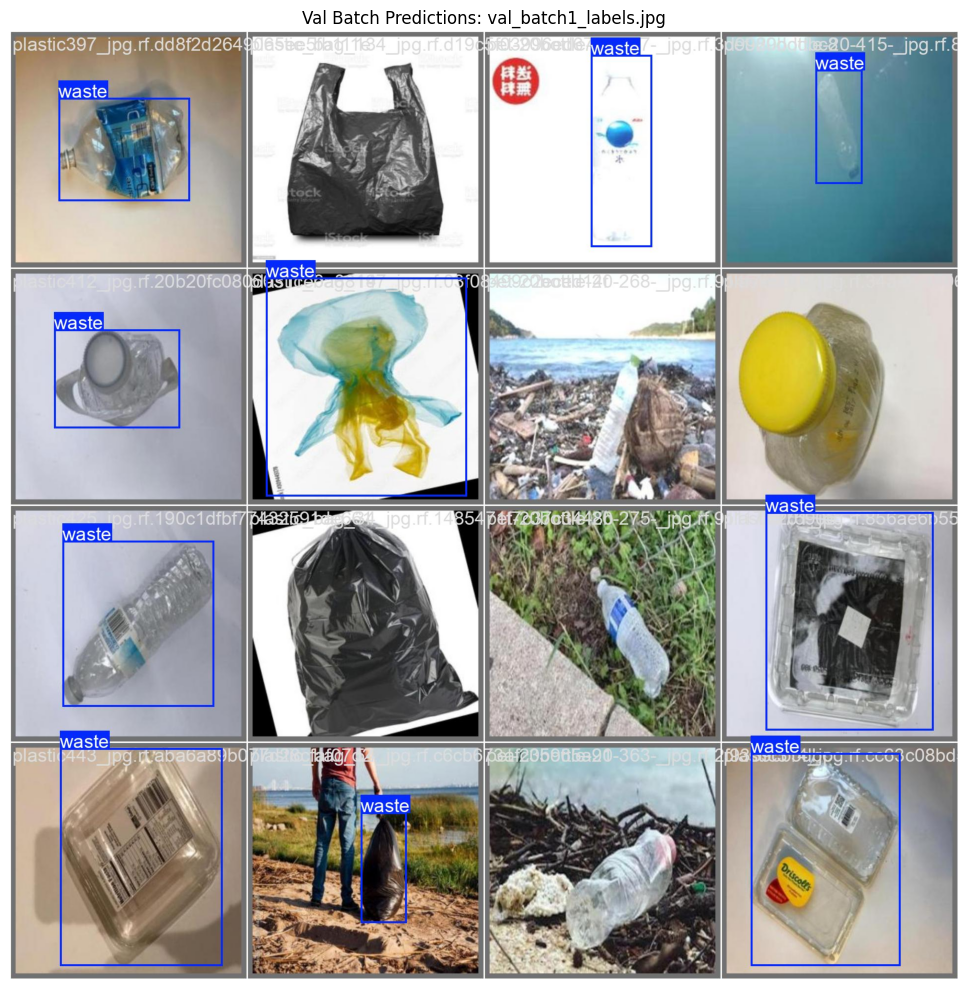

  - val_batch1_pred.jpg


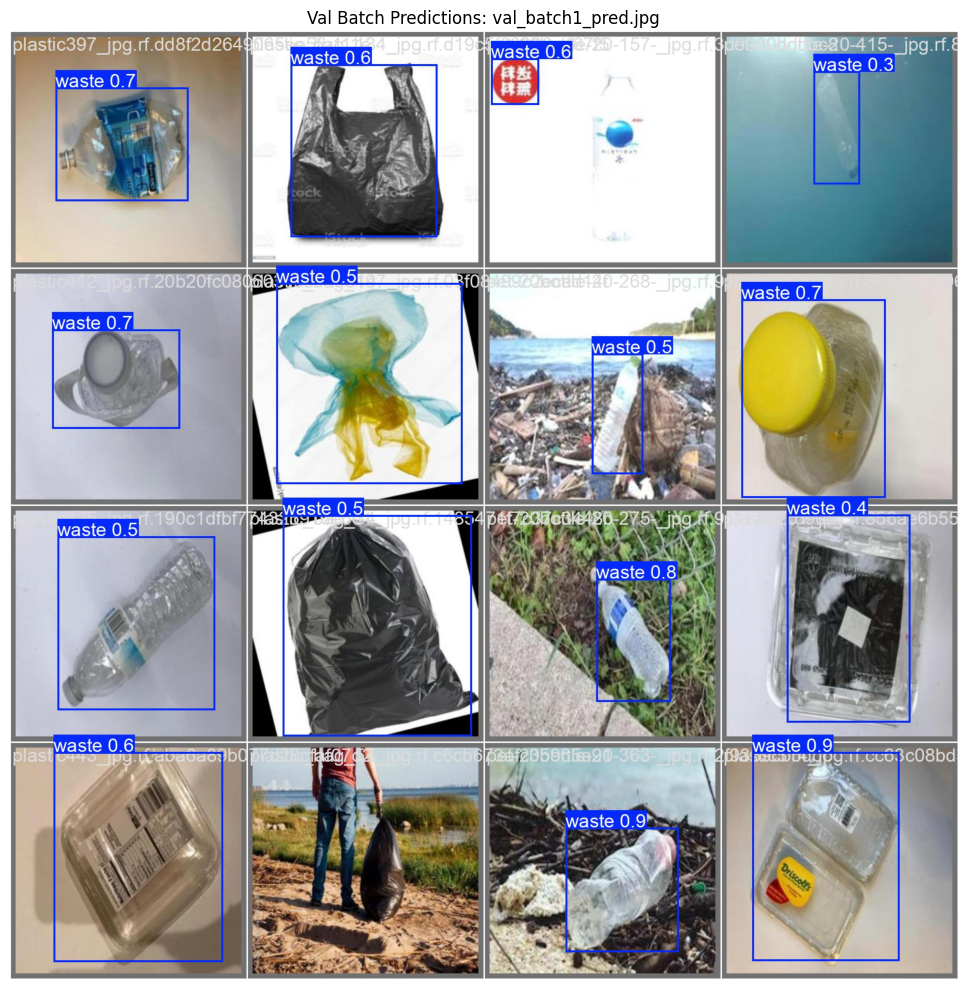

  - ... and 3 more


In [49]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os
from IPython.display import display, HTML

# Define function to find and display saved visualizations
def display_yolo_visualizations(model_dir):
    """Find and display visualizations saved by YOLO during training and validation"""

    # Dictionary to hold different types of visualizations
    viz_files = {
        'Confusion Matrix': [],
        'PR Curve': [],
        'F1 Confidence': [],
        'Results': [],
        'Val Batch Predictions': []
    }

    # Find visualization files - check multiple possible locations
    search_dirs = [
        f"{model_dir}/runs/detect/train*/",
        f"{model_dir}/runs/train*/",
        f"{model_dir}/"
    ]

    for search_dir in search_dirs:
        # Confusion matrix
        viz_files['Confusion Matrix'].extend(glob.glob(f"{search_dir}*confusion_matrix*.png"))

        # PR curve
        viz_files['PR Curve'].extend(glob.glob(f"{search_dir}*PR_curve*.png"))

        # F1 confidence curve
        viz_files['F1 Confidence'].extend(glob.glob(f"{search_dir}*F1_curve*.png"))

        # Results plot
        viz_files['Results'].extend(glob.glob(f"{search_dir}*results*.png"))

        # Validation predictions
        viz_files['Val Batch Predictions'].extend(glob.glob(f"{search_dir}*val_batch*.jpg"))

    # Display each type of visualization
    found_any = False

    print("=== YOLO Generated Visualizations ===")
    for viz_type, file_list in viz_files.items():
        if file_list:
            found_any = True
            print(f"\n{viz_type} ({len(file_list)} files found):")

            # Display up to 3 files of each type
            for i, file_path in enumerate(file_list[:3]):
                print(f"  - {os.path.basename(file_path)}")

                plt.figure(figsize=(12, 10))
                img = mpimg.imread(file_path)
                plt.imshow(img)
                plt.axis('off')
                plt.title(f"{viz_type}: {os.path.basename(file_path)}")
                plt.tight_layout()
                plt.show()

            # If more than 3 files, just list the rest
            if len(file_list) > 3:
                print(f"  - ... and {len(file_list) - 3} more")

    if not found_any:
        print("No visualization files found in the expected locations.")
        print("Directories searched:")
        for search_dir in search_dirs:
            print(f"  - {search_dir}")

        # List the contents of the model directory to help troubleshoot
        print("\nContents of model directory:")
        !find {model_dir} -type f -name "*.png" -o -name "*.jpg" | sort

# Call the function with your model directory
display_yolo_visualizations('/content/models/yolov83')

testing the model




0: 640x640 1 pet, 9.9ms
Speed: 2.8ms preprocess, 9.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 spill, 7.8ms
Speed: 3.6ms preprocess, 7.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.4ms
Speed: 3.0ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 waste, 7.4ms
Speed: 3.3ms preprocess, 7.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 home_object, 7.4ms
Speed: 2.9ms preprocess, 7.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 waste, 7.4ms
Speed: 3.1ms preprocess, 7.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 home_objects, 7.4ms
Speed: 3.2ms preprocess, 7.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


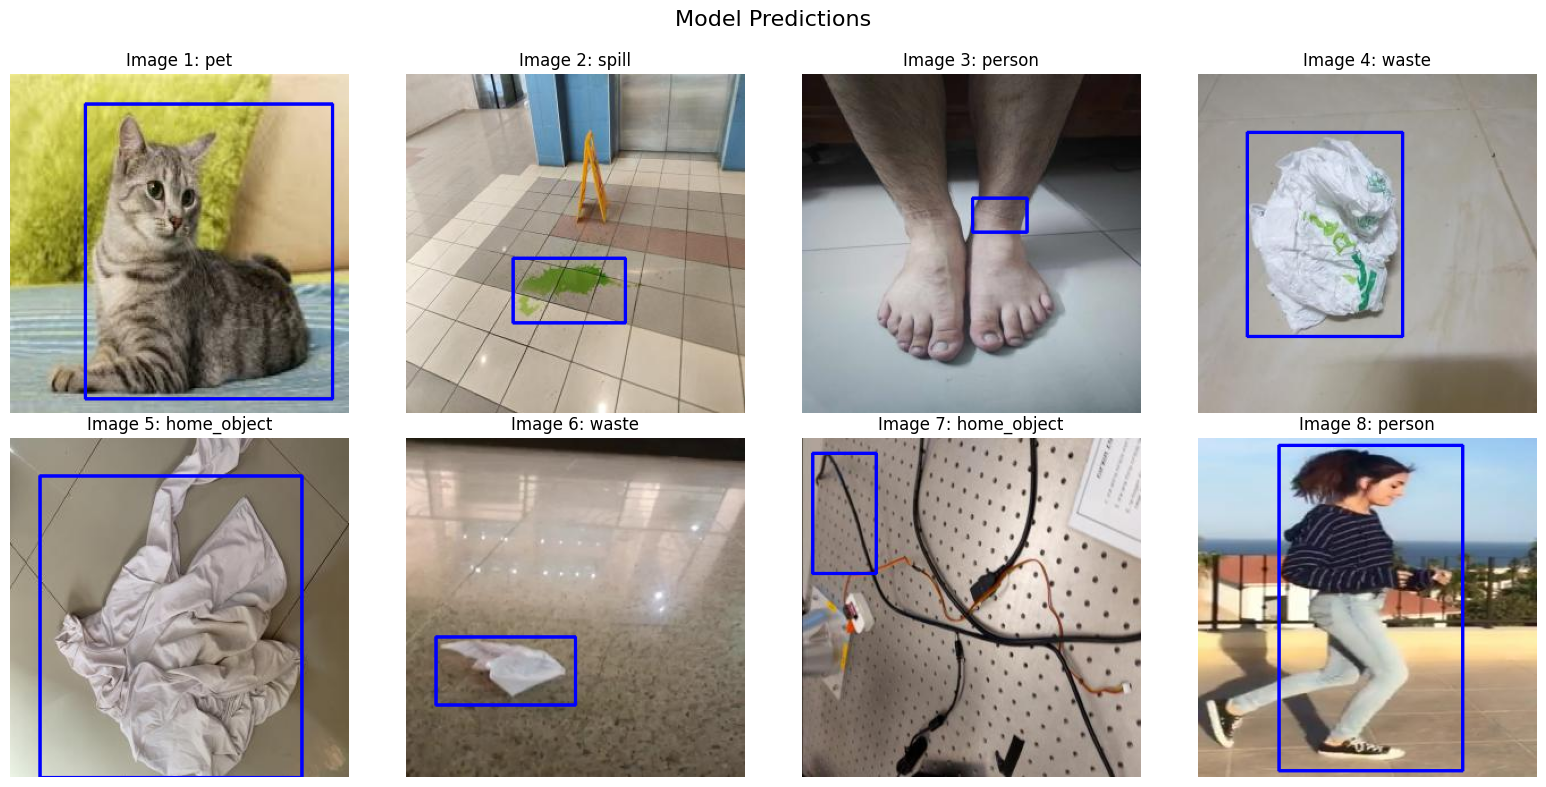

In [48]:
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random

# Load YOLO model
model_path = '/content/models/yolov83/weights/best.pt'
model = YOLO(model_path)

# Define class mapping (reverse mapping)
reverse_label_mapping = {
    0: 'waste',
    1: 'home_object',
    2: 'pet',
    3: 'person',
    4: 'spill',
    5: 'dirt'
}

def load_image(path):
    """Load an image from a given path."""
    image = cv2.imread(path)
    if image is None:
        print(f"Error loading image from {path}")
    return image

def process_image(image, model):
    """Process and predict on the loaded image using YOLO."""
    # Create a copy of the original image for annotation
    original_height, original_width = image.shape[:2]

    # YOLO model accepts the original image without resizing
    results = model.predict(image, conf=0.25)[0]  # Get first result

    # Create a copy for annotation and resize for display
    image_resized = cv2.resize(image, (299, 299))
    image_annotated = image_resized.copy()

    # Get predictions
    if len(results.boxes) > 0:
        # Get the highest confidence prediction
        conf_vals = results.boxes.conf.cpu().numpy()
        if len(conf_vals) > 0:
            best_idx = np.argmax(conf_vals)

            # Get box coordinates (normalized format in YOLO)
            box = results.boxes.xyxy[best_idx].cpu().numpy()
            cls_id = int(results.boxes.cls[best_idx].cpu().numpy())

            # Scale box coordinates to 299x299 for display
            x1, y1, x2, y2 = box
            x1_scaled = int(x1 * 299 / original_width)
            y1_scaled = int(y1 * 299 / original_height)
            x2_scaled = int(x2 * 299 / original_width)
            y2_scaled = int(y2 * 299 / original_height)

            # Draw bounding box
            image_annotated = cv2.rectangle(image_annotated,
                                          (x1_scaled, y1_scaled),
                                          (x2_scaled, y2_scaled),
                                          (255, 0, 0), 2)

            # Get the predicted class label
            prediction = reverse_label_mapping[cls_id]

            return image_annotated, prediction

    # Default return if no prediction with confidence above threshold
    return image_resized, "No detection"

def predict_random_xml_and_image(xml_folder, image_folder, model):
    """
    Selects random XML files from the xml_folder, loads corresponding images from the image_folder,
    and makes predictions using the provided model.
    Args:
    xml_folder: Path to the folder containing XML files.
    image_folder: Path to the folder containing image files.
    model: Pretrained YOLO model instance.
    """
    xml_files = [f for f in os.listdir(xml_folder) if f.endswith('.xml')]
    if not xml_files:
        print("No XML files found in the specified folder.")
        return

    # Choose a random set of 8 XML files
    random_xml_files = random.sample(xml_files, min(8, len(xml_files)))

    images = []
    predictions = []

    for random_xml_file in random_xml_files:
        base_name = os.path.splitext(random_xml_file)[0]
        image_file = os.path.join(image_folder, base_name + '.jpg')

        if not os.path.exists(image_file):
            print(f"Image file not found: {image_file}")
            continue

        image = load_image(image_file)
        images.append(image)

        # Get the model prediction
        annotated_image, prediction = process_image(image, model)
        predictions.append((annotated_image, prediction))

    # Display images and predictions
    display_predictions(images, predictions)

def display_predictions(images, predictions):
    """Display images with predictions below each image in a grid."""
    # Create a 2x4 grid for 8 images
    fig, axs = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle('Model Predictions', fontsize=16)

    for i, (ax, (img, prediction)) in enumerate(zip(axs.flatten(), predictions), start=1):
        # Convert BGR to RGB for display
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.axis('off')

        # Set title with image number and prediction
        ax.set_title(f'Image {i}: {prediction}', fontsize=12)

    plt.tight_layout(pad=1.2, h_pad=1)
    plt.subplots_adjust(top=0.9)  # Adjust title position
    plt.show()

# Define paths
xml_folder_path = '/content/cleaning_bot_object_dataset/xmls'
image_folder_path = '/content/cleaning_bot_object_dataset/images'

# Call the prediction function with the model
predict_random_xml_and_image(xml_folder_path, image_folder_path, model)